In [61]:
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
import sys
sys.path.append('/home/esther/lc-mapping/scripts')
import landcover_definitions as lc
import util
from importlib import reload

# important for changing fonts in 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [59]:
classes_keep = [1,2,3,4,6]

def reindex_ea(array_in, classes_keep):
    ignore_index = len(classes_keep)
    reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
    # reindex shrub to tree
    tree_idx = 3 # tree idx is 3 when there are no zeros
    shrub_idx = 5
    reindexed_mask = -1 * np.ones(array_in.shape)
    for old_idx, new_idx in reindex_map.items():
        reindexed_mask[array_in == old_idx] = new_idx

    reindexed_mask[reindexed_mask == -1] = ignore_index

    return reindexed_mask

colors = [lc.lc_colors['enviroatlas'][c] for c in classes_keep]

pittsburgh_pa-2010_1m
durham_nc-2012_1m
austin_tx-2012_1m
phoenix_az-2010_1m


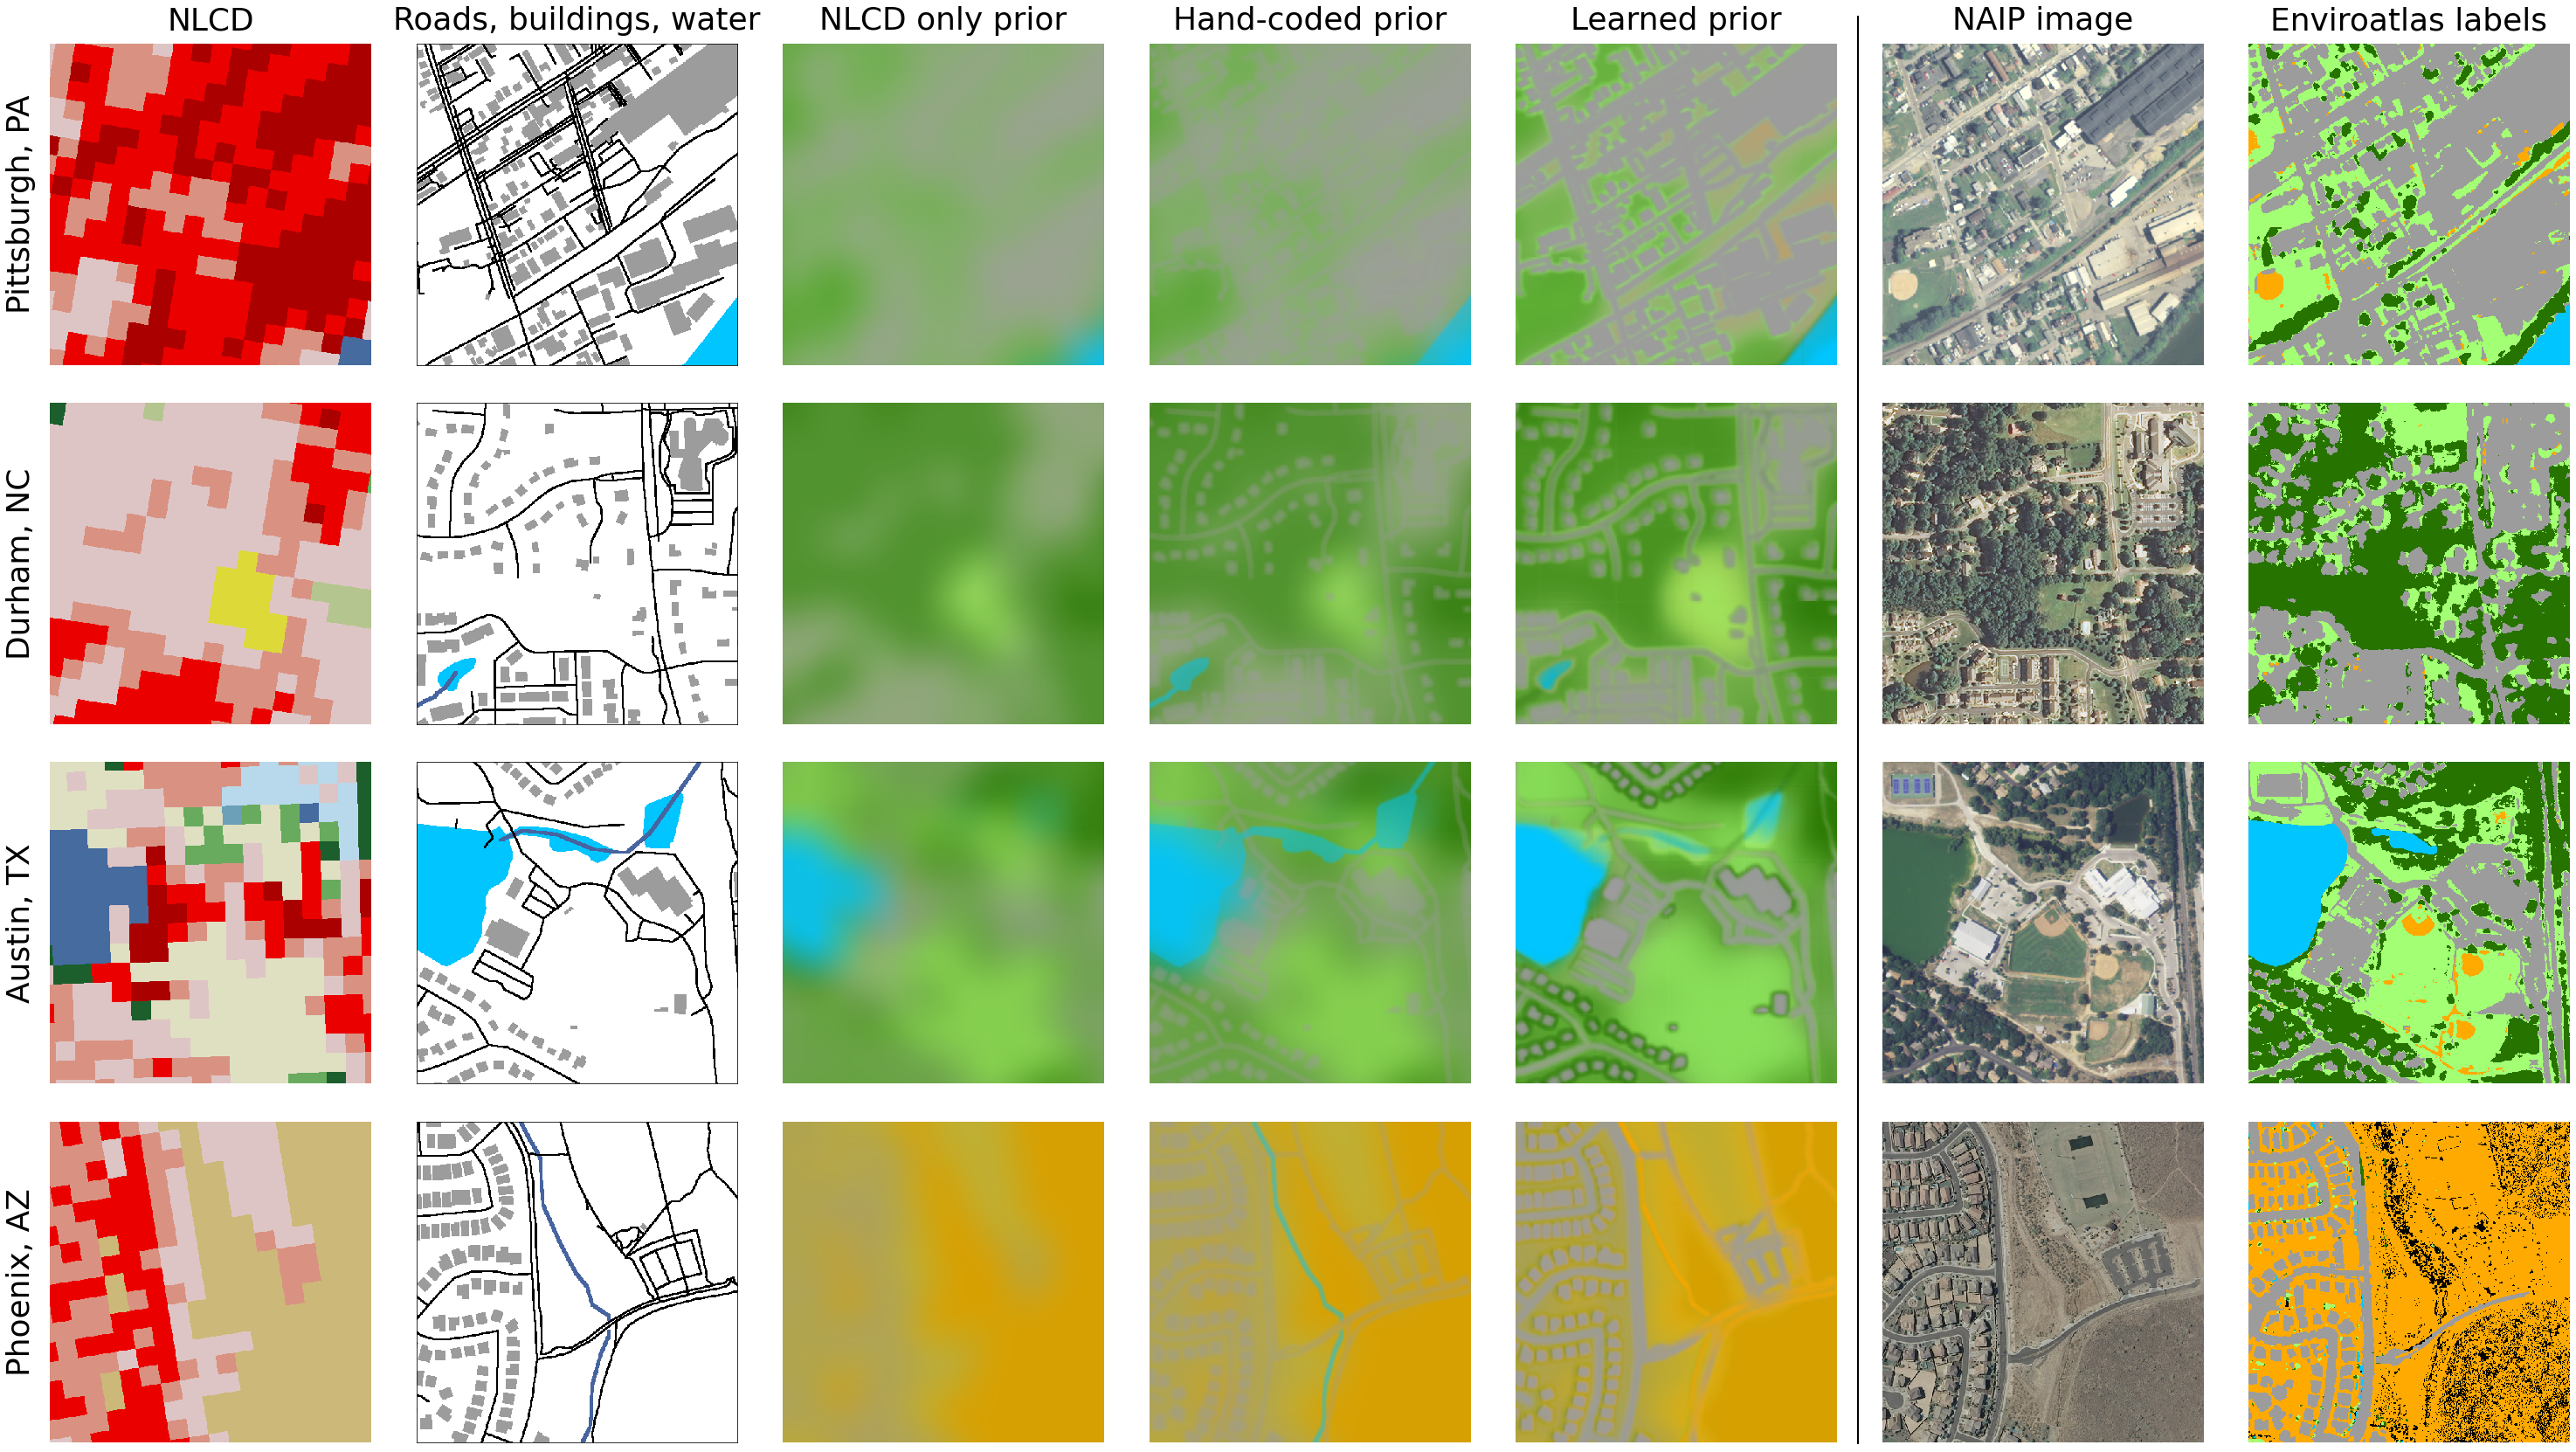

In [86]:
reload(lc)

#states = []

states = ['pittsburgh_pa-2010_1m',
          'durham_nc-2012_1m',
          'austin_tx-2012_1m', 
          'phoenix_az-2010_1m'
         ]

state_names = {'pittsburgh_pa-2010_1m':'Pittsburgh, PA',
               'durham_nc-2012_1m': 'Durham, NC',
              'austin_tx-2012_1m': 'Austin, TX',
              'phoenix_az-2010_1m': 'Phoenix, AZ'}

tile_ids_to_plot = {'phoenix_az-2010_1m': [4],
                    'durham_nc-2012_1m': [1],
                    'austin_tx-2012_1m': [2],
                    'pittsburgh_pa-2010_1m': [4]}

plot_bounds_states = { 'phoenix_az-2010_1m': [[2000,2500,1300,1800]],
                       'durham_nc-2012_1m': [[3000,3500,1500,2000]],
                       'austin_tx-2012_1m': [[2800,3300,1300,1800]],
                      'pittsburgh_pa-2010_1m': [[500,1000,500,1000]]}


fig, ax = plt.subplots(4,7, figsize=(42,24))


for s,state in enumerate(states):
    
    print(state)
    
    tile_ids = np.unique([x[:10] for x in os.listdir(f'/home/esther/torchgeo_data/enviroatlas/{state}-test_tiles-debuffered/')])

    
    for t, tile_id_idx in enumerate(tile_ids_to_plot[state]):
        tile_id = tile_ids[tile_id_idx]
        
        h1, h2, w1, w2 = plot_bounds_states[state][t]

        image_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-test_tiles-debuffered/{tile_id}_a_naip.tif'
        learned_prior_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-test_tiles-debuffered/{tile_id}_prior_learned_101_31.tif'
        prior_fn  = f'/home/esther/torchgeo_data/enviroatlas/{state}-test_tiles-debuffered/{tile_id}_prior_from_cooccurrences_101_31.tif'
        label_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-test_tiles-debuffered/{tile_id}_h_highres_labels.tif'

        prior_no_osm_fn = prior_fn.replace('.tif', '_no_osm_no_buildings.tif')
        nlcd_fn = image_fn.replace('a_naip', 'b_nlcd')
        roads_fn = image_fn.replace('a_naip', 'c_roads')
        buildings_fn = image_fn.replace('a_naip', 'e_buildings')
        waterways_fn = image_fn.replace('a_naip', 'd1_waterways')
        waterbodies_fn = image_fn.replace('a_naip', 'd2_waterbodies')
        
        #h1, h2, w1, w2 = 200,400, 2800, 3000
        
        
        prior_no_osm = rasterio.open(prior_no_osm_fn).read()[:,h1:h2,w1:w2]

        nlcd = rasterio.open(nlcd_fn).read()[0,h1:h2,w1:w2]
        waterways = util.blur(rasterio.open(waterways_fn).read()[0,h1:h2,w1:w2], 1)
        waterbodies = rasterio.open(waterbodies_fn).read()[0,h1:h2,w1:w2]
        buildings = rasterio.open(buildings_fn).read()[0,h1:h2,w1:w2]
        roads = rasterio.open(roads_fn).read()[0,h1:h2,w1:w2]
        built = np.maximum(buildings, roads)
        water = np.maximum(waterways, waterbodies)
         
#         impervious_idx = 2
#         water_idx = 1
#         osm_data = np.zeros(water.shape)
#         osm_data[water > 0 ] = water_idx
#         osm_data[built > 0] = impervious_idx

        osm_data = np.zeros(water.shape)
        osm_data[waterbodies > 0] = water_idx
        osm_data[waterways > 0] = 12
        osm_data[roads > 0] = 11
        osm_data[buildings > 0] = impervious_idx
        
        learned_prior = rasterio.open(learned_prior_fn).read()[:,h1:h2,w1:w2]
        handmade_prior = rasterio.open(prior_fn).read()[:,h1:h2,w1:w2]
        img = rasterio.open(image_fn).read()[:,h1:h2,w1:w2]
        h = lc.map_raw_lc_to_idx['enviroatlas'][rasterio.open(label_fn).read()[0,h1:h2,w1:w2]]

        h_copy = h.copy()
        for i, cls in enumerate(classes_keep):
            h_copy[h == cls] = i

        
        ax[s,0].imshow(lc.vis_lc(nlcd, 'nlcd').T.swapaxes(0,1),interpolation='none')   
        ax[s,2].imshow(lc.vis_lc_from_colors(prior_no_osm, colors).T.swapaxes(0,1),interpolation='none')      
        ax[s,1].imshow(lc.vis_lc(osm_data, 'enviroatlas').T.swapaxes(0,1),interpolation='none')                       
        ax[s,3].imshow(lc.vis_lc_from_colors(handmade_prior, colors).T.swapaxes(0,1),interpolation='none')
        ax[s,4].imshow(lc.vis_lc_from_colors(learned_prior, colors).T.swapaxes(0,1),interpolation='none')
        ax[s,5].imshow(img[:3].T.swapaxes(0,1),interpolation='none')    
        ax[s,6].imshow(lc.vis_lc_from_colors(h_copy, colors).T.swapaxes(0,1),interpolation='none')
        
        
        fs = 36
        tp = 16
        if s == 0:
            ax[s,0].set_title('NLCD', fontsize=fs, pad=tp)
            ax[s,2].set_title('NLCD only prior', fontsize=fs, pad=tp)
            ax[s,1].set_title('Roads, buildings, water', fontsize=fs, pad=tp)
            ax[s,3].set_title('Hand-coded prior', fontsize=fs, pad=tp)
            ax[s,4].set_title('Learned prior', fontsize=fs, pad=tp)
            ax[s,5].set_title('NAIP image', fontsize=fs, pad=tp)
            ax[s,6].set_title('Enviroatlas labels', fontsize=fs, pad=tp)

        
                        
        for c in range(7): 
            if c != 1:
                # turn off the box
                for key, spine in ax[s,c].spines.items():
                    spine.set_visible(False)
            ax[s,c].get_xaxis().set_visible(False)
            #ax[c].get_yaxis().set_visible(False)
            ax[s,c].set_yticklabels([])
            ax[s,c].set_yticks([])
            
            
        
        # turn this label back on
     #   ax[s,0].get_yaxis().set_visible(True)
        ax[s,0].set_ylabel(state_names[state], fontsize=fs, labelpad = tp)

line = plt.Line2D([0.7155,0.7155],[0.025,.97], linewidth = 2, transform=fig.transFigure, color="black")
fig.add_artist(line)
                        
fig.tight_layout(pad=4.0)

plt.savefig('../figures/prior_generation_mosaic.pdf', bbox_inches='tight')
                        
                        

In [4]:
'durham_nc-2012_1m', 
'austin_tx-2012_1m',

('austin_tx-2012_1m',)